In [17]:
# -*- coding: utf-8 -*-
"""VAE_FashionMnist_CNN.ipynb"""

import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [18]:

# Load and preprocess Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [19]:

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [48]:


tf.random.set_seed(42)

codings_size = 4

# ============================================
# CNN ENCODER
# ============================================
inputs = tf.keras.layers.Input(shape=[28, 28, 1])

# Convolutional layers to extract spatial features
Z = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)  # 14x14x32
Z = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(Z)      # 7x7x64
Z = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(Z)     # 4x4x128

# Flatten for latent space projection
Z = tf.keras.layers.Flatten()(Z)  # 4*4*128 = 2048
Z = tf.keras.layers.Dense(256, activation="relu")(Z)

# Latent space parameters
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [49]:

# ============================================
# CNN DECODER
# ============================================
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])

# Project to feature map size
x = tf.keras.layers.Dense(256, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(4 * 4 * 128, activation="relu")(x)
x = tf.keras.layers.Reshape([4, 4, 128])(x)

# Transposed convolutions to upsample
x = tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)  # 8x8x128
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)   # 16x16x64
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)   # 32x32x32

# Final convolution to get single channel output
x = tf.keras.layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")(x)  # 32x32x1

# Crop to match original size (28x28)
outputs = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)  # 28x28x1

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [50]:
# ============================================
# COMPLETE VAE MODEL
# ============================================
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

print("=" * 60)
print("ENCODER ARCHITECTURE")
print("=" * 60)
print(variational_encoder.summary())

print("\n" + "=" * 60)
print("DECODER ARCHITECTURE")
print("=" * 60)
print(variational_decoder.summary())

ENCODER ARCHITECTURE
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 14, 14, 32)           320       ['input_12[0][0]']            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 7, 7, 64)             18496     ['conv2d_23[0][0]']           
                                                                                                  
 conv2d_25 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_24[0][0]']           
                                                                      

In [51]:



# ============================================
# LOSS FUNCTION WITH KL DIVERGENCE AS A LAYER
# ============================================
# Add KL divergence as a loss directly to the model
kl_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.square(codings_mean) - tf.exp(codings_log_var),
    axis=-1
)
variational_ae.add_loss(tf.reduce_mean(kl_loss) / (28.0 * 28.0))

# Reconstruction loss function
def reconstruction_loss(y_true, y_pred):
    return 1000 * tf.reduce_mean(tf.square(y_true - y_pred))


In [52]:


# ============================================
# TRAINING
# ============================================
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
variational_ae.compile(optimizer=opt, loss=reconstruction_loss)

history = variational_ae.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_valid, X_valid)
)


Epoch 1/50
430/430 [==============================] - 11s 15ms/step - loss: 77.9904 - val_loss: 35.6076
Epoch 2/50
430/430 [==============================] - 7s 17ms/step - loss: 29.5630 - val_loss: 26.9688
Epoch 3/50
430/430 [==============================] - 6s 14ms/step - loss: 25.5074 - val_loss: 24.6986
Epoch 4/50
430/430 [==============================] - 6s 14ms/step - loss: 24.0171 - val_loss: 23.6537
Epoch 5/50
430/430 [==============================] - 6s 14ms/step - loss: 23.0782 - val_loss: 22.8566
Epoch 6/50
430/430 [==============================] - 6s 14ms/step - loss: 22.3852 - val_loss: 22.2262
Epoch 7/50
430/430 [==============================] - 6s 15ms/step - loss: 21.8101 - val_loss: 21.7278
Epoch 8/50
430/430 [==============================] - 6s 14ms/step - loss: 21.3328 - val_loss: 21.2673
Epoch 9/50
430/430 [==============================] - 6s 15ms/step - loss: 20.9296 - val_loss: 21.1126
Epoch 10/50
430/430 [==============================] - 6s 14ms/step - lo

1/1 [==============================] - 0s 94ms/step


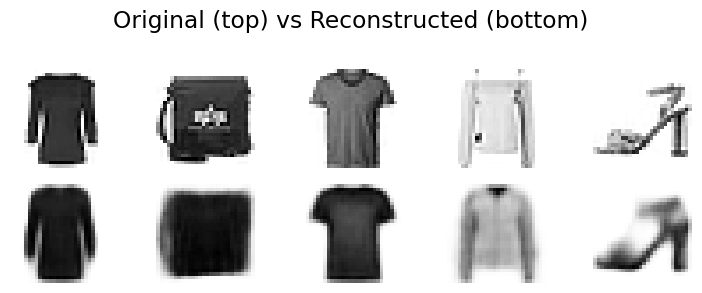

In [55]:

# ============================================
# VISUALIZATION FUNCTIONS
# ============================================
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index].squeeze(), cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index].squeeze(), cmap="binary")
        plt.axis("off")
    plt.suptitle("Original (top) vs Reconstructed (bottom)")
    plt.tight_layout()

plot_reconstructions(variational_ae)
plt.show()

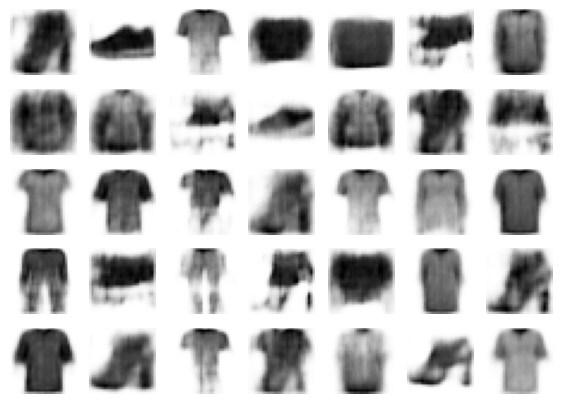

In [56]:
# ============================================
# TESTING: GENERATE NEW IMAGES
# ============================================
tf.random.set_seed(42)

codings = tf.random.normal(shape=[35, codings_size])
images = variational_decoder(codings).numpy()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_cnn_generated_images_plot", tight_layout=False)
plt.show()

1719/1719 [==============================] - 3s 2ms/step


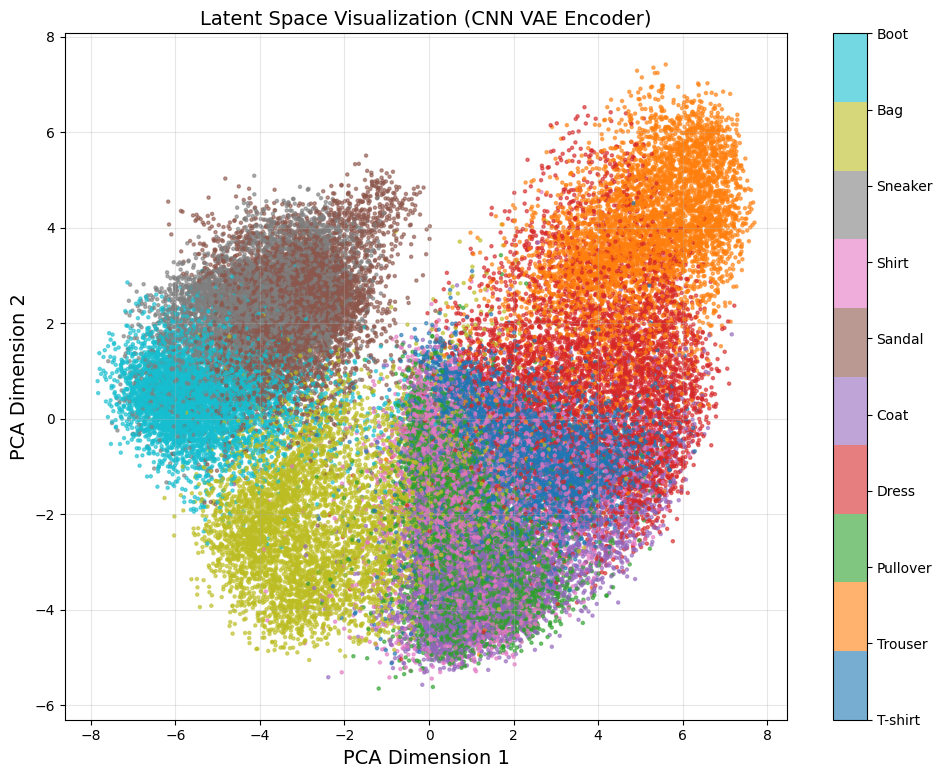

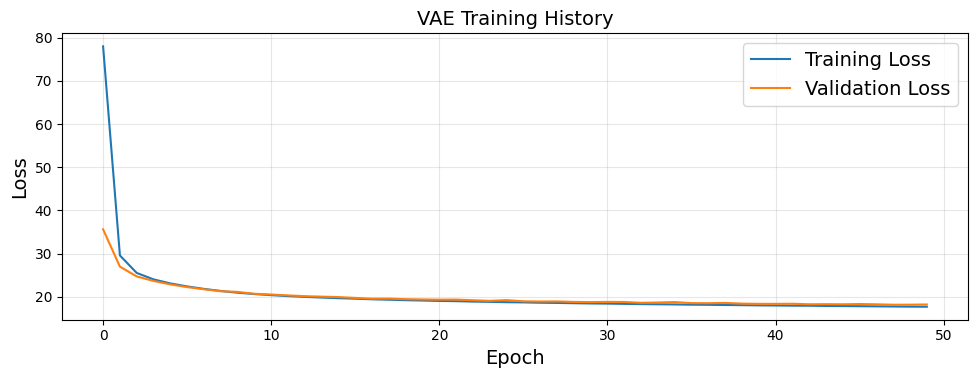

In [57]:







# ============================================
# LATENT SPACE VISUALIZATION
# ============================================
from sklearn.decomposition import PCA

# Pass training data through encoder
z_mean, z_log_var, z = variational_encoder.predict(X_train)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z_mean)

# Visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_train, cmap="tab10", s=5, alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(10))
cbar.set_ticklabels([
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Boot"
])

plt.title("Latent Space Visualization (CNN VAE Encoder)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# TRAINING HISTORY
# ============================================
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training History')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()